In [2]:
#Miles' packages
from astropy.table import Table
import astropy.coordinates as coord
import glob
from astropy import units as u

#data processing
import pandas as pd
import numpy as np
import math as math
from tqdm import tqdm
import collections

#visualizations
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.use('Agg')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

#models
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#data manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

#for my sanity
import warnings
warnings.filterwarnings('ignore')

In [3]:
from astroquery.gaia import Gaia

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [4]:
stream_data_base = 'gaia_mock_streams/'
stream_files = glob.glob(stream_data_base + 'stream*.fits.gz')

We now have all the stream files:

In [5]:
print(len(stream_files))
stream_files[:5]

322


['gaia_mock_streams/stream-178.fits.gz',
 'gaia_mock_streams/stream-9528.fits.gz',
 'gaia_mock_streams/stream-9549.fits.gz',
 'gaia_mock_streams/stream-1954.fits.gz',
 'gaia_mock_streams/stream-2408.fits.gz']

In [6]:
#relevant cut for each stream
cuts = pd.read_csv('cuts.csv')
print(len(cuts))
cuts.head()

10


,stream_file,ra_min,ra_max,dec_min,dec_max
0,gaia_mock_streams/stream-178.fits.gz,300,350,-10,50
1,gaia_mock_streams/stream-9528.fits.gz,200,350,-70,-30
2,gaia_mock_streams/stream-9549.fits.gz,200,250,-20,40
3,gaia_mock_streams/stream-1954.fits.gz,30,220,-90,-20
4,gaia_mock_streams/stream-2408.fits.gz,180,250,-50,-20


In [10]:
table = Table.read(stream_files[0], format='fits')
stream = table.to_pandas()

ra_min = cuts.loc[0].ra_min
ra_max = cuts.loc[0].ra_max
dec_min = cuts.loc[0].dec_min
dec_max = cuts.loc[0].dec_max

#restrict stream to relevant portion
stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

#label our data as "part of the stream"
stream['stream_mask'] = True

#split data into training and training data set
msk = np.random.rand(len(stream)) < 0.9
stream_train = stream[msk]
stream_test = stream[~msk]


#obtain noise points such that:
#- the ratio of stream to noise points in the training set is 2:1 i.e. strong signal
#- the ratio of stream to noise points in the test set is 1:100 i.e. realistic
n_points = len(stream_train) // 2 + len(stream_test) * 100

#use max_rel_err of 0.5
max_rel_err =  0.5

#we now select our noise points that we will incorporate into our training and test set
noise_points = obtain_noise(ra_min, ra_max, dec_min, dec_max, max_rel_err, n_points)

#label our data as "not part of the stream"
noise_points['stream_mask'] = False

INFO: Query finished. [astroquery.utils.tap.core]


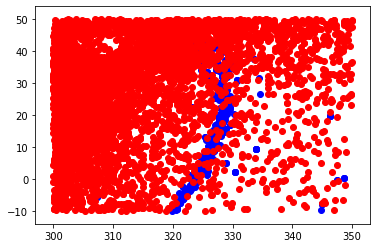

In [12]:
plt.scatter(stream.ra, stream.dec, color = 'b')
plt.scatter(noise_points.ra, noise_points.dec, color = 'r')

In [7]:
#let us write a function to extract the Gaia noise points based on some inputs
def obtain_noise(min_ra, max_ra, min_dec, max_dec, max_rel_err, n_points):
    
    qry = f" \n\
    select top {n_points} source_id, \n\
    dr2.ra, \n\
    dr2.dec, \n\
    parallax, \n\
    parallax_error, \n\
    pmra, \n\
    pmdec, \n\
    phot_g_mean_mag,\n\
    phot_bp_mean_mag, \n\
    phot_rp_mean_mag, \n\
    bp_rp, \n\
    bp_g, \n\
    g_rp\n\
    from gaiadr2.gaia_source as dr2 \n\
    where dr2.ra > {min_ra} and dr2.ra < {max_ra} and dr2.dec > {min_dec} and dr2.dec < {max_dec} \n\
    and parallax is not null \n\
    and parallax_error is not null \n\
    and abs(dr2.parallax/dr2.parallax_error) < {max_rel_err} \n\
    and pmra is not null \n\
    and pmdec is not null \n\
    and phot_g_mean_mag is not null \n\
    and phot_bp_mean_mag is not null \n\
    and phot_rp_mean_mag is not null \n\
    and bp_rp is not null \n\
    and bp_g is not null \n\
    and g_rp is not null \n\
    order by random_index"

    data_noise = Gaia.launch_job_async(qry).get_results().to_pandas()
    
    return data_noise

#### Let us define our potential models here

In [11]:
#let us define a function to run logistic regression on our data set and evaluate the results
def log_reg_model(X_train, X_test, y_train, y_test):
    #do the logistic regression modeling
    log_reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, multi_class='warn').fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc

def knn_model(X_train, X_test, y_train, y_test, k):
    #do the KNN modeling
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc

#### Let us try to use our stellar streams to obtain logistic regression models

In [16]:
# precisions_simulated = []
# recalls_simulated = []
# accuracy_simulated = []
# auc_simulated = []

# for i in range(len(cuts)):
#     table = Table.read(stream_files[i], format='fits')
#     stream = table.to_pandas()

#     ra_min = cuts.loc[i].ra_min
#     ra_max = cuts.loc[i].ra_max
#     dec_min = cuts.loc[i].dec_min
#     dec_max = cuts.loc[i].dec_max

#     #restrict stream to relevant portion
#     stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

#     #label our data as "part of the stream"
#     stream['stream_mask'] = True

#     #split data into training and training data set
#     msk = np.random.rand(len(stream)) < 0.9
#     stream_train = stream[msk]
#     stream_test = stream[~msk]


#     #obtain noise points such that:
#     #- the ratio of stream to noise points in the training set is 2:1 i.e. strong signal
#     #- the ratio of stream to noise points in the test set is 1:100 i.e. realistic
#     n_points = len(stream_train) // 2 + len(stream_test) * 100

#     #use max_rel_err of 0.5
#     max_rel_err =  0.5

#     #we now select our noise points that we will incorporate into our training and test set
#     noise_points = obtain_noise(ra_min, ra_max, dec_min, dec_max, max_rel_err, n_points)

#     #label our data as "not part of the stream"
#     noise_points['stream_mask'] = False

#     msk2 = np.random.rand(len(noise_points)) < (len(stream_train) // 2 / n_points)
#     noise_train = noise_points[msk2]
#     noise_test = noise_points[~msk2]

#     #combine my stream and noise to obtain complete training and test data set
#     training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
#     training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]

#     testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
#     testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]

#     #differentiate training and test data's X and y variables
#     X_train = training_data[['ra', 'dec', 'pmra', 'pmdec']]
#     y_train = training_data.stream_mask

#     X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec']]
#     y_test = testing_data.stream_mask

#     #scale the features using standard scaler (scaling not required for logistic regression)
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit(X_train).transform(X_train)
#     X_test_scaled = scaler.fit(X_test).transform(X_test)

#     precision_log_reg, recall_log_reg, accuracy_log_reg, auc_log_reg = log_reg_model(X_train, X_test, y_train, y_test)
    
#     precisions_simulated.append(precision_log_reg)
#     recalls_simulated.append(recall_log_reg)
#     accuracy_simulated.append(accuracy_log_reg)
#     auc_simulated.append(auc_log_reg)


INFO: Query finished. [astroquery.utils.tap.core]


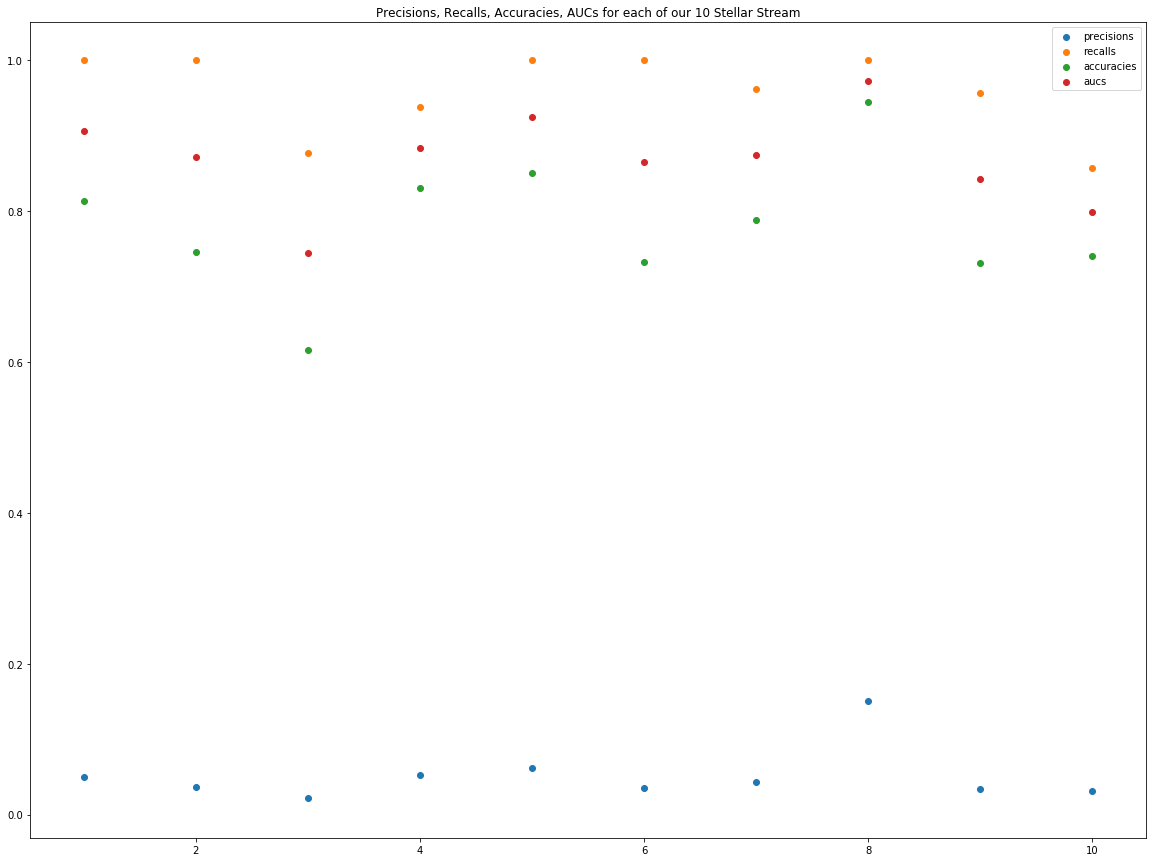

In [74]:
# fig = plt.figure(figsize = (20,15))
# simulated_streams_index = [i for i in range(1,len(cuts)+1)]

# plt.scatter(simulated_streams_index, precisions_simulated, label = 'precisions')
# plt.scatter(simulated_streams_index, recalls_simulated, label = 'recalls')
# plt.scatter(simulated_streams_index, accuracy_simulated, label = 'accuracies')
# plt.scatter(simulated_streams_index, auc_simulated, label = 'aucs')
# plt.title('Precisions, Recalls, Accuracies, AUCs for each of our ' + str(len(cuts)) + ' Stellar Stream')

# plt.legend()

#### Do KNN for one of the stellar streams. This should help us select the best k to use moving forward.

In [12]:
# precisions_simulated_knn = []
# recalls_simulated_knn = []
# accuracy_simulated_knn = []
# auc_simulated_knn = []

# for i in range(1):
#     table = Table.read(stream_files[i], format='fits')
#     stream = table.to_pandas()

#     ra_min = cuts.loc[i].ra_min
#     ra_max = cuts.loc[i].ra_max
#     dec_min = cuts.loc[i].dec_min
#     dec_max = cuts.loc[i].dec_max

#     #restrict stream to relevant portion
#     stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

#     #label our data as "part of the stream"
#     stream['stream_mask'] = True

#     #split data into training and training data set
#     msk = np.random.rand(len(stream)) < 0.9
#     stream_train = stream[msk]
#     stream_test = stream[~msk]


#     #obtain noise points such that:
#     #- the ratio of stream to noise points in the training set is 2:1 i.e. strong signal
#     #- the ratio of stream to noise points in the test set is the same as for the test set
#     multiple = 25
#     n_points = (len(stream_train) + len(stream_test)) * multiple

#     #use max_rel_err of 0.5
#     max_rel_err =  0.5

#     #we now select our noise points that we will incorporate into our training and test set
#     noise_points = obtain_noise(ra_min, ra_max, dec_min, dec_max, max_rel_err, n_points)

#     #label our data as "not part of the stream"
#     noise_points['stream_mask'] = False

#     msk2 = np.random.rand(len(noise_points)) < (len(stream_train) * multiple / n_points)
#     noise_train = noise_points[msk2]
#     noise_test = noise_points[~msk2]

#     #combine my stream and noise to obtain complete training and test data set
#     training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
#     training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]

#     testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
#     testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]

#     #differentiate training and test data's X and y variables
#     X_train = training_data[['ra', 'dec', 'pmra', 'pmdec']]
#     y_train = training_data.stream_mask

#     X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec']]
#     y_test = testing_data.stream_mask

#     #scale the features using standard scaler (scaling not required for logistic regression)
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit(X_train).transform(X_train)
#     X_test_scaled = scaler.fit(X_test).transform(X_test)

#     k_options = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
#     precisions_knn = []
#     recalls_knn = []
#     accuracies_knn = []
#     aucs_knn = []

#     #run KNN for every k-value
#     for k in k_options:
#         precision_k, recall_k, accuracy_k, auc_k = knn_model(X_train_scaled, X_test_scaled, y_train, y_test, k)
#         precisions_knn.append(precision_k)
#         recalls_knn.append(recall_k)
#         accuracies_knn.append(accuracy_k)
#         aucs_knn.append(auc_k)
#         if k%5==0:
#             print('k = ' + str(k) + ' is done ...')


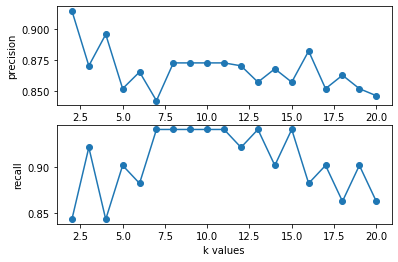

In [95]:
#visualize the KNN metrics
plt.subplot(2, 1, 1)
plt.plot(k_options, precisions_knn, 'o-')
plt.xlabel('k values')
plt.ylabel('precision')

plt.subplot(2, 1, 2)
plt.plot(k_options, recalls_knn, 'o-')
plt.xlabel('k values')
plt.ylabel('recall')

plt.show()

Text(0, 0.5, 'auc')

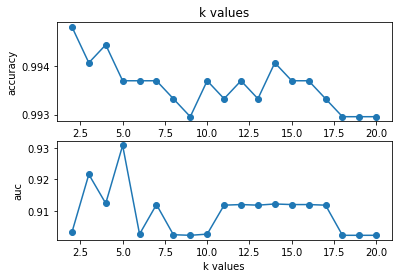

In [89]:
plt.subplot(2, 1, 1)
plt.plot(k_options, accuracies_knn, 'o-')
plt.title('k values')
plt.ylabel('accuracy')

plt.subplot(2, 1, 2)
plt.plot(k_options, aucs_knn, 'o-')
plt.xlabel('k values')
plt.ylabel('auc')

### For the sake of it, let us select 8 as optimal for k and re-run in all streams

In [9]:
def knn_simulated_stream(k_optimal, train_ratio, multiple):

    precisions_simulated_knn = []
    recalls_simulated_knn = []
    accuracy_simulated_knn = []
    auc_simulated_knn = []

    for i in range(len(cuts)):
        table = Table.read(stream_files[i], format='fits')
        stream = table.to_pandas()

        ra_min = cuts.loc[i].ra_min
        ra_max = cuts.loc[i].ra_max
        dec_min = cuts.loc[i].dec_min
        dec_max = cuts.loc[i].dec_max

        #restrict stream to relevant portion
        stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

        #label our data as "part of the stream"
        stream['stream_mask'] = True

        #split data into training and training data set
        msk = np.random.rand(len(stream)) < 0.9
        stream_train = stream[msk]
        stream_test = stream[~msk]


        #obtain noise points such that:
        #- the ratio of stream to noise points in the training set is 1:multiple i.e. weak but realistic signal
        #- the ratio of stream to noise points in the test set is the same as for the test set
        #- this is required because KNN introduces bias when the ratios are imbalanced
        n_points = (len(stream_train) + len(stream_test)) * multiple

        #use max_rel_err of 0.5
        max_rel_err =  0.5

        #we now select our noise points that we will incorporate into our training and test set
        noise_points = obtain_noise(ra_min, ra_max, dec_min, dec_max, max_rel_err, n_points)

        #label our data as "not part of the stream"
        noise_points['stream_mask'] = False

        msk2 = np.random.rand(len(noise_points)) < 0.9 #(len(stream_train) * multiple / n_points)
        noise_train = noise_points[msk2]
        noise_test = noise_points[~msk2]

        #combine my stream and noise to obtain complete training and test data set
        training_data = stream_train.append(noise_train, ignore_index = False, sort = True)
        training_data = training_data[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]

        testing_data = stream_test.append(noise_test, ignore_index = False, sort = True)
        testing_data = testing_data[['ra', 'dec', 'pmra', 'pmdec', 'stream_mask']]

        #differentiate training and test data's X and y variables
        X_train = training_data[['ra', 'dec', 'pmra', 'pmdec']]
        y_train = training_data.stream_mask

        X_test = testing_data[['ra', 'dec', 'pmra', 'pmdec']]
        y_test = testing_data.stream_mask

        #scale the features using standard scaler (scaling not required for logistic regression)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit(X_train).transform(X_train)
        X_test_scaled = scaler.fit(X_test).transform(X_test)

        k = k_optimal
        precisions_knn = []
        recalls_knn = []
        accuracies_knn = []
        aucs_knn = []

        precision_k, recall_k, accuracy_k, auc_k = knn_model(X_train_scaled, X_test_scaled, y_train, y_test, k)
        precisions_simulated_knn.append(precision_k)
        recalls_simulated_knn.append(recall_k)
        accuracy_simulated_knn.append(accuracy_k)
        auc_simulated_knn.append(auc_k)
        
    return precisions_simulated_knn, recalls_simulated_knn, accuracy_simulated_knn, auc_simulated_knn


#### We are not hyperparameter tuning so much as we are quantifying anticipated model degradation as we:
##### - reduce the ratio of data that we claim to know
##### - increase the multiple of foreground data we introduce to our analysis

In [ ]:
k_optimal = 8
train_ratio = [.1*i for i in range(1,10)] #how many of the stellar stream points do we claim to know the label for?
multiple = [50,75,100,150,200] #how many non-stellar streams do we bring from the foreground into the data set?
dict_results = {}

count = 0
for ratio in train_ratio:
    for mult in multiple:
        count +=1
        precs, recs, accs, aucs = knn_simulated_stream(k_optimal, ratio, mult)
        key = (ratio, mult)
        dict_results[key] = [precs, recs, accs, aucs]
        print('iteration ' + str(count) + ' of 45 is complete...')

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


#### Let us visualize the precisions and recalls as we change our training_ratio and multiple

In [15]:
training_ratio = [i[0] for i in list(dict_results.keys())]
multiple = [i[1] for i in list(dict_results.keys())]
precisions = [sum(i[0])/len(i[0]) for i in list(dict_results.values())]
recalls = [sum(i[1])/len(i[1]) for i in list(dict_results.values())]

In [22]:
df_results = pd.DataFrame({'training_ratio':training_ratio, 'multiple':multiple, 'precision':precisions, 'recall':recalls})
df_results.to_csv('ratio_mult_precision_recall.csv')

Text(0.5, 0, 'precisions')

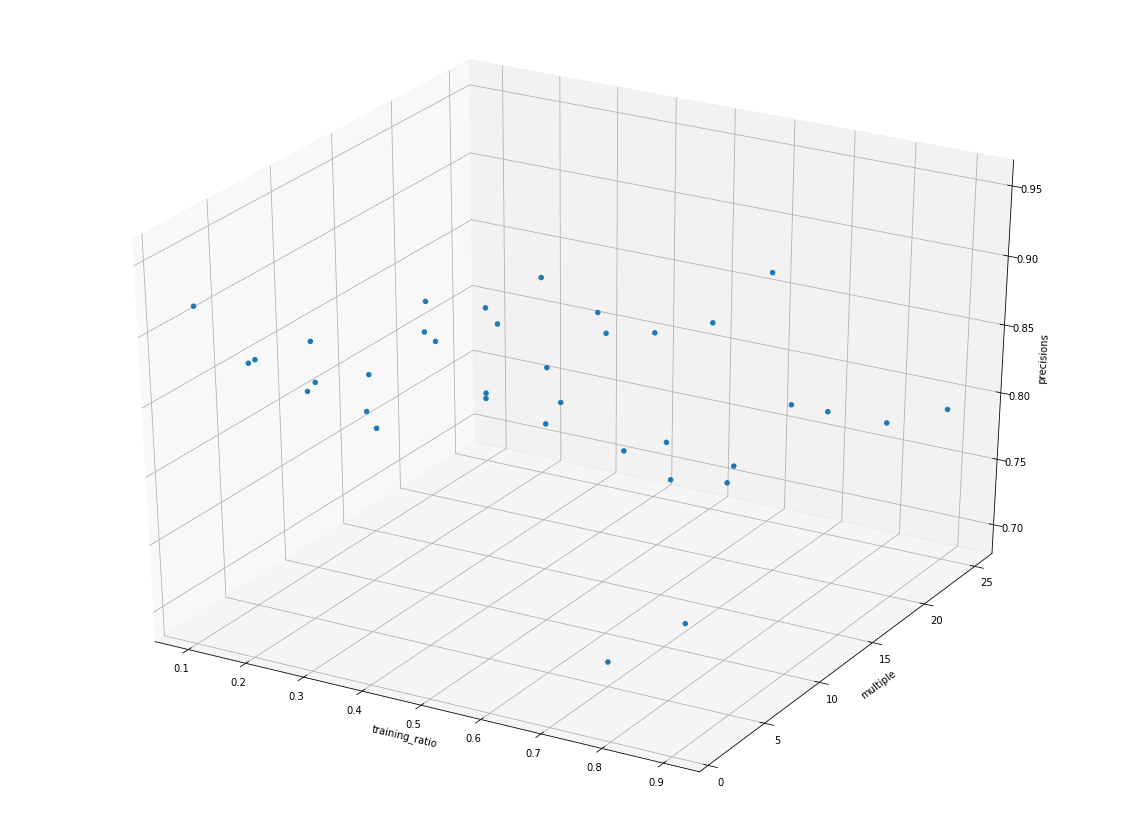

In [16]:
results = pd.read_csv('ratio_mult_precision_recall.csv')

#precisions
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results.training_ratio, results.multiple, results.precision, alpha = 1)
ax.set_xlabel('training_ratio')
ax.set_ylabel('multiple')
ax.set_zlabel('precisions')

Text(0.5, 0, 'recalls')

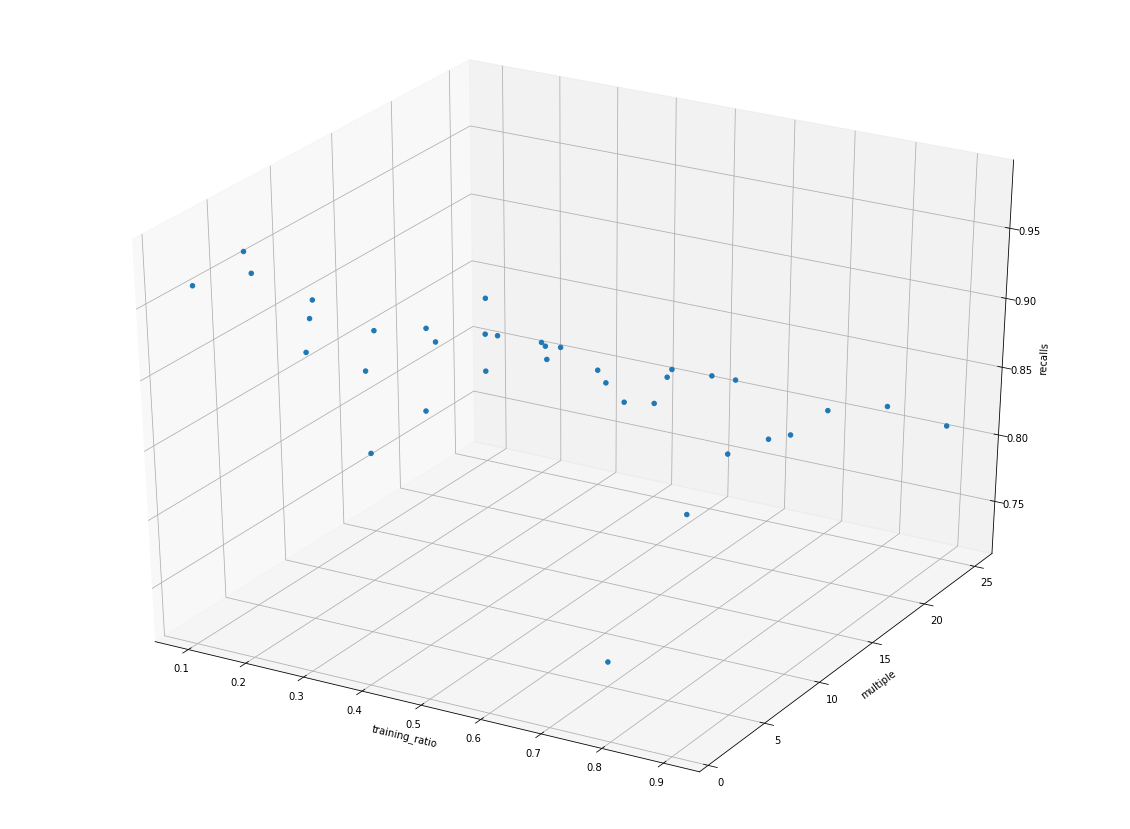

In [17]:
#recalls
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results.training_ratio, results.multiple, results.recall, alpha = 1)
ax.set_xlabel('training_ratio')
ax.set_ylabel('multiple')
ax.set_zlabel('recalls')

#### Consider we are interested in visualizing the model's predictions vs. the actual results. The following filters help visualize those results.

In [32]:
X_correct = X_test[y_test & y_pred]
X_incorrect = X_test[y_test & ~y_pred]

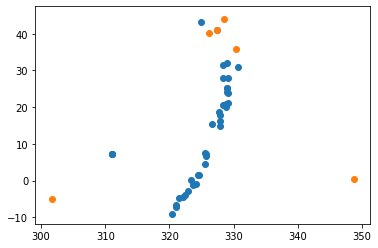

In [33]:
plt.scatter(X_correct['ra'], X_correct['dec'])
plt.scatter(X_incorrect['ra'], X_incorrect['dec'])

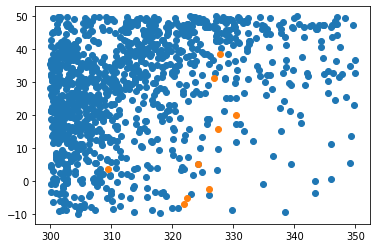

In [35]:
X2_correct = X_test[~y_test & ~y_pred]
X2_incorrect = X_test[~y_test & y_pred]

plt.scatter(X2_correct['ra'], X2_correct['dec'])
plt.scatter(X2_incorrect['ra'], X2_incorrect['dec'])

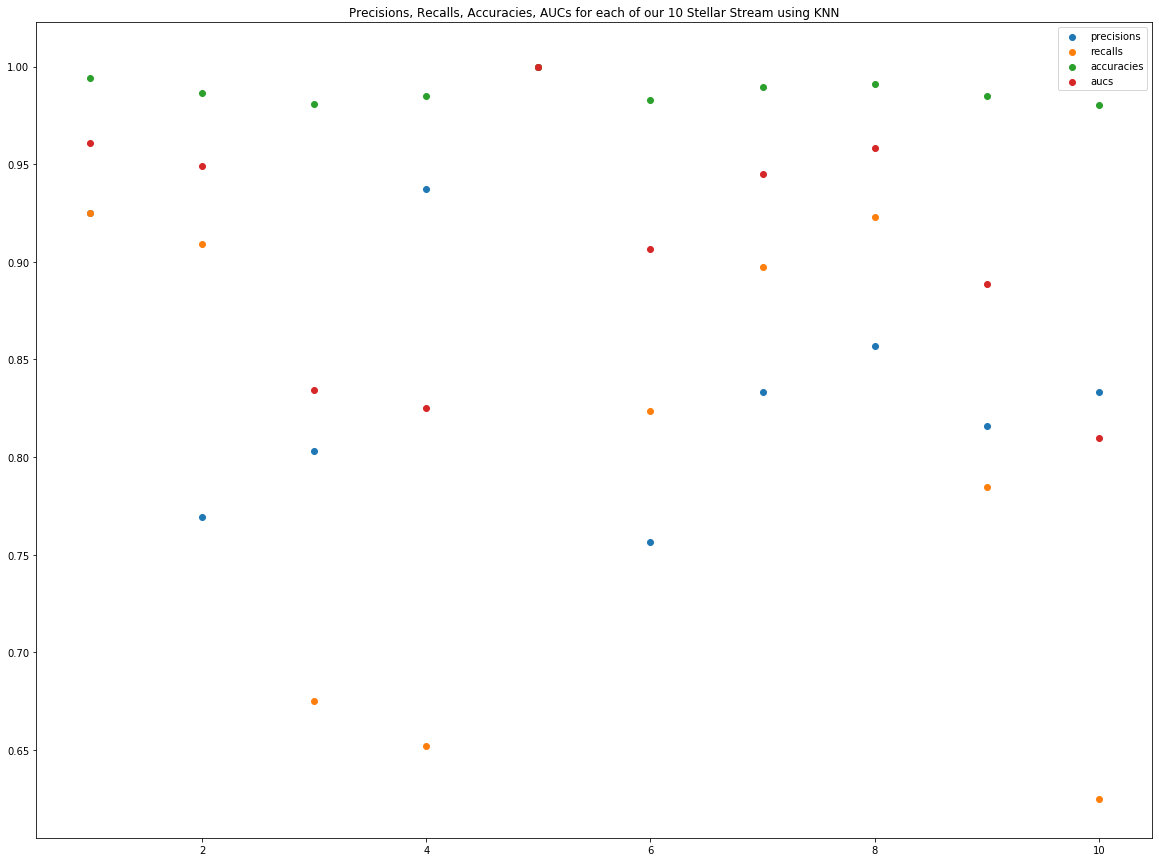

In [98]:
fig = plt.figure(figsize = (20,15))
simulated_streams_index = [i for i in range(1,len(cuts)+1)]

plt.scatter(simulated_streams_index, precisions_simulated_knn, label = 'precisions')
plt.scatter(simulated_streams_index, recalls_simulated_knn, label = 'recalls')
plt.scatter(simulated_streams_index, accuracy_simulated_knn, label = 'accuracies')
plt.scatter(simulated_streams_index, auc_simulated_knn, label = 'aucs')
plt.title('Precisions, Recalls, Accuracies, AUCs for each of our ' + str(len(cuts)) + ' Stellar Stream using KNN')

plt.legend()

In [99]:
print('The average precision through KNN is: ' + str(sum(precisions_simulated_knn)/len(cuts)))
print('The average recall through KNN is: ' + str(sum(recalls_simulated_knn)/len(cuts)))
print('The average accuracy through KNN is: ' + str(sum(accuracy_simulated_knn)/len(cuts)))
print('The average AUC through KNN is: ' + str(sum(auc_simulated_knn)/len(cuts)))

The average precision through KNN is: 0.8531116826511564
The average recall through KNN is: 0.8215276416662981
The average accuracy through KNN is: 0.9875389641150127
The average AUC through KNN is: 0.9078559133379018
